In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

/Users/sang-geon/Documents/UCI_BIASLab/HDC_Robustness/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
train_data.data.shape, train_data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [6]:
X_train = X_train.reshape(-1, 28*28) / 255
X_test = X_test.reshape(-1, 28*28) / 255

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [8]:
original_dim = 28*28
dim = 10000

In [9]:
encoder = robustness_model.FHRREncoder(original_dim, dim)
model = robustness_model.MultiClassificationModel(encoder, 10, in_dim=original_dim, dim=dim)
model.bundling(X_train, y_train)

100%|██████████| 45/45 [04:20<00:00,  5.79s/it]


In [10]:
def overall_robustness(model: robustness_model.MultiClassificationModel, c1, c2, X):
    
    ep1s = []
    ep2s = []
    ep3s = []

    # L3 = model.get_lipschitz_constant()

    max_X, method2_history = model.get_lipschitz_constant_gd(c1, c2)
    L2 = method2_history[-1]
    max_X, L, method3_history = model.get_conservative_lipschitz_constant_gd(c1, c2)
    L3 = L

    # plt.plot(method2_history)
    # plt.ylabel('$|| \\nabla r(x) ||$')
    # plt.xlabel('Iteration')
    # plt.show()

    # plt.plot(method3_history)
    # plt.ylabel('$\\alpha$')
    # plt.xlabel('Iteration')
    # plt.show()
    
    for x in tqdm.tqdm(X):
        
        L1 = model.get_linear_approximation(c1, c2, x)
        # L2 = model.get_conservative_lipschitz_constant(x)

        ep1 = model.get_eps(c1, c2, x, L1)
        ep2 = model.get_eps(c1, c2, x, L2)
        ep3 = model.get_eps(c1, c2, x, L3)

        ep1s.append(ep1)
        ep2s.append(ep2)
        ep3s.append(ep3)
    
    return torch.tensor(ep1s), torch.tensor(ep2s), torch.tensor(ep3s)

In [11]:
all_train_robustness = []
i = 0
for c1 in range(10):
    for c2 in range(c1 + 1, 10):
        ep1s_train, ep2s_train, ep3s_train = overall_robustness(model, c1, c2, X_train[(y_train == c1) | (y_train == c2)])
        print(c1, c2, ep1s_train.mean(), ep2s_train.mean(), ep3s_train.mean())
        all_train_robustness.append((ep1s_train, ep2s_train, ep3s_train))
        i += 1


100%|██████████| 12665/12665 [01:38<00:00, 128.05it/s]


0 1 tensor(0.1052) tensor(0.0415) tensor(0.0171)


100%|██████████| 11881/11881 [01:32<00:00, 128.98it/s]


0 2 tensor(0.0495) tensor(0.0189) tensor(0.0077)


100%|██████████| 12054/12054 [01:31<00:00, 132.08it/s]


0 3 tensor(0.0498) tensor(0.0190) tensor(0.0077)


100%|██████████| 11765/11765 [01:27<00:00, 135.21it/s]


0 4 tensor(0.0498) tensor(0.0187) tensor(0.0077)


100%|██████████| 11344/11344 [01:24<00:00, 133.63it/s]


0 5 tensor(0.0508) tensor(0.0193) tensor(0.0079)


100%|██████████| 11841/11841 [01:23<00:00, 141.50it/s]


0 6 tensor(0.0499) tensor(0.0190) tensor(0.0078)


100%|██████████| 12188/12188 [01:25<00:00, 142.31it/s]


0 7 tensor(0.0494) tensor(0.0189) tensor(0.0077)


100%|██████████| 11774/11774 [01:23<00:00, 141.82it/s]


0 8 tensor(0.0498) tensor(0.0188) tensor(0.0077)


100%|██████████| 11872/11872 [01:23<00:00, 141.57it/s]


0 9 tensor(0.0498) tensor(0.0191) tensor(0.0077)


100%|██████████| 12700/12700 [01:29<00:00, 142.48it/s]


1 2 tensor(0.0284) tensor(0.0108) tensor(0.0044)


100%|██████████| 12873/12873 [01:30<00:00, 142.01it/s]


1 3 tensor(0.1015) tensor(0.0406) tensor(0.0165)


100%|██████████| 12584/12584 [01:28<00:00, 142.30it/s]


1 4 tensor(0.1034) tensor(0.0412) tensor(0.0168)


100%|██████████| 12163/12163 [01:25<00:00, 142.50it/s]


1 5 tensor(0.1058) tensor(0.0422) tensor(0.0172)


100%|██████████| 12660/12660 [01:28<00:00, 143.34it/s]


1 6 tensor(0.1032) tensor(0.0411) tensor(0.0168)


100%|██████████| 13007/13007 [01:32<00:00, 141.30it/s]


1 7 tensor(0.1010) tensor(0.0403) tensor(0.0164)


100%|██████████| 12593/12593 [01:28<00:00, 142.48it/s]


1 8 tensor(0.1031) tensor(0.0406) tensor(0.0168)


100%|██████████| 12691/12691 [01:28<00:00, 143.21it/s]


1 9 tensor(0.1027) tensor(0.0411) tensor(0.0167)


100%|██████████| 12089/12089 [01:24<00:00, 143.14it/s]


2 3 tensor(0.0287) tensor(0.0108) tensor(0.0044)


100%|██████████| 11800/11800 [01:22<00:00, 142.98it/s]


2 4 tensor(0.0290) tensor(0.0109) tensor(0.0045)


100%|██████████| 11379/11379 [01:20<00:00, 142.21it/s]


2 5 tensor(0.0289) tensor(0.0109) tensor(0.0045)


100%|██████████| 11876/11876 [01:23<00:00, 142.39it/s]


2 6 tensor(0.0388) tensor(0.0149) tensor(0.0060)


100%|██████████| 12223/12223 [01:25<00:00, 142.96it/s]


2 7 tensor(0.0386) tensor(0.0147) tensor(0.0060)


100%|██████████| 11809/11809 [01:22<00:00, 142.40it/s]


2 8 tensor(0.0393) tensor(0.0149) tensor(0.0061)


100%|██████████| 11907/11907 [01:23<00:00, 142.39it/s]


2 9 tensor(0.0392) tensor(0.0151) tensor(0.0061)


100%|██████████| 11973/11973 [01:23<00:00, 143.21it/s]


3 4 tensor(0.0392) tensor(0.0148) tensor(0.0061)


100%|██████████| 11552/11552 [01:20<00:00, 143.30it/s]


3 5 tensor(0.0388) tensor(0.0148) tensor(0.0060)


100%|██████████| 12049/12049 [01:24<00:00, 142.55it/s]


3 6 tensor(0.0386) tensor(0.0148) tensor(0.0060)


100%|██████████| 12396/12396 [01:28<00:00, 140.62it/s]


3 7 tensor(0.0392) tensor(0.0149) tensor(0.0061)


100%|██████████| 11982/11982 [01:23<00:00, 142.69it/s]


3 8 tensor(0.0384) tensor(0.0146) tensor(0.0060)


100%|██████████| 12080/12080 [01:28<00:00, 136.84it/s]


3 9 tensor(0.0389) tensor(0.0146) tensor(0.0060)


100%|██████████| 11263/11263 [01:22<00:00, 136.69it/s]


4 5 tensor(0.0284) tensor(0.0108) tensor(0.0044)


100%|██████████| 11760/11760 [01:26<00:00, 136.60it/s]


4 6 tensor(0.0283) tensor(0.0107) tensor(0.0044)


100%|██████████| 12107/12107 [01:28<00:00, 136.74it/s]


4 7 tensor(0.0285) tensor(0.0108) tensor(0.0044)


100%|██████████| 11693/11693 [01:25<00:00, 136.81it/s]


4 8 tensor(0.0286) tensor(0.0110) tensor(0.0044)


100%|██████████| 11791/11791 [01:25<00:00, 138.67it/s]


4 9 tensor(0.0390) tensor(0.0148) tensor(0.0061)


100%|██████████| 11339/11339 [01:20<00:00, 141.13it/s]


5 6 tensor(0.0395) tensor(0.0149) tensor(0.0061)


100%|██████████| 11686/11686 [01:24<00:00, 137.95it/s]


5 7 tensor(0.0400) tensor(0.0152) tensor(0.0062)


100%|██████████| 11272/11272 [01:19<00:00, 142.55it/s]


5 8 tensor(0.0395) tensor(0.0151) tensor(0.0061)


100%|██████████| 11370/11370 [01:28<00:00, 128.34it/s]


5 9 tensor(0.0396) tensor(0.0151) tensor(0.0062)


100%|██████████| 12183/12183 [01:32<00:00, 131.52it/s]


6 7 tensor(0.0286) tensor(0.0109) tensor(0.0045)


100%|██████████| 11769/11769 [01:26<00:00, 135.35it/s]


6 8 tensor(0.0285) tensor(0.0109) tensor(0.0044)


100%|██████████| 11867/11867 [01:19<00:00, 148.68it/s]


6 9 tensor(0.0392) tensor(0.0149) tensor(0.0061)


100%|██████████| 12116/12116 [01:18<00:00, 154.56it/s]


7 8 tensor(0.0312) tensor(0.0120) tensor(0.0048)


100%|██████████| 12214/12214 [01:18<00:00, 154.64it/s]


7 9 tensor(0.0286) tensor(0.0107) tensor(0.0044)


100%|██████████| 11800/11800 [01:20<00:00, 147.42it/s]


8 9 tensor(0.0394) tensor(0.0151) tensor(0.0061)


In [13]:
all_test_robustness = []
i = 0
for c1 in range(10):
    for c2 in range(c1 + 1, 10):
        ep1s_test, ep2s_test, ep3s_test = overall_robustness(model, c1, c2, X_test[(y_test == c1) | (y_test == c2)])
        print(c1, c2, ep1s_test.mean(), ep2s_test.mean(), ep3s_test.mean())
        all_test_robustness.append((ep1s_test, ep2s_test, ep3s_test))
        i += 1


100%|██████████| 2115/2115 [00:15<00:00, 139.79it/s]


0 1 tensor(0.0966) tensor(0.0386) tensor(0.0158)


100%|██████████| 2012/2012 [00:16<00:00, 125.69it/s]


0 2 tensor(0.0285) tensor(0.0110) tensor(0.0044)


100%|██████████| 1990/1990 [00:15<00:00, 132.63it/s]


0 3 tensor(0.0282) tensor(0.0106) tensor(0.0044)


100%|██████████| 1962/1962 [00:14<00:00, 132.79it/s]


0 4 tensor(0.0289) tensor(0.0109) tensor(0.0045)


100%|██████████| 1872/1872 [00:14<00:00, 131.96it/s]


0 5 tensor(0.0288) tensor(0.0109) tensor(0.0045)


100%|██████████| 1938/1938 [00:14<00:00, 133.22it/s]


0 6 tensor(0.0291) tensor(0.0111) tensor(0.0045)


100%|██████████| 2008/2008 [00:14<00:00, 134.87it/s]


0 7 tensor(0.0292) tensor(0.0111) tensor(0.0045)


100%|██████████| 1954/1954 [00:14<00:00, 134.17it/s]


0 8 tensor(0.0287) tensor(0.0109) tensor(0.0045)


100%|██████████| 1989/1989 [00:14<00:00, 134.08it/s]


0 9 tensor(0.0282) tensor(0.0107) tensor(0.0044)


100%|██████████| 2167/2167 [00:16<00:00, 133.73it/s]


1 2 tensor(0.0280) tensor(0.0107) tensor(0.0043)


100%|██████████| 2145/2145 [00:15<00:00, 135.42it/s]


1 3 tensor(0.0958) tensor(0.0379) tensor(0.0157)


100%|██████████| 2117/2117 [00:15<00:00, 136.11it/s]


1 4 tensor(0.0959) tensor(0.0382) tensor(0.0157)


100%|██████████| 2027/2027 [00:14<00:00, 136.38it/s]


1 5 tensor(0.1001) tensor(0.0400) tensor(0.0164)


100%|██████████| 2093/2093 [00:15<00:00, 133.76it/s]


1 6 tensor(0.0980) tensor(0.0393) tensor(0.0160)


100%|██████████| 2163/2163 [00:15<00:00, 135.54it/s]


1 7 tensor(0.0955) tensor(0.0382) tensor(0.0156)


100%|██████████| 2109/2109 [00:19<00:00, 110.10it/s]


1 8 tensor(0.0960) tensor(0.0387) tensor(0.0157)


100%|██████████| 2144/2144 [00:16<00:00, 127.76it/s]


1 9 tensor(0.0961) tensor(0.0380) tensor(0.0157)


100%|██████████| 2042/2042 [00:16<00:00, 127.24it/s]


2 3 tensor(0.0280) tensor(0.0106) tensor(0.0043)


100%|██████████| 2014/2014 [00:16<00:00, 119.14it/s]


2 4 tensor(0.0277) tensor(0.0105) tensor(0.0043)


100%|██████████| 1924/1924 [00:15<00:00, 127.58it/s]


2 5 tensor(0.0289) tensor(0.0111) tensor(0.0045)


100%|██████████| 1990/1990 [00:14<00:00, 135.17it/s]


2 6 tensor(0.0281) tensor(0.0106) tensor(0.0044)


100%|██████████| 2060/2060 [00:15<00:00, 136.86it/s]


2 7 tensor(0.0287) tensor(0.0110) tensor(0.0045)


100%|██████████| 2006/2006 [00:14<00:00, 136.88it/s]


2 8 tensor(0.0284) tensor(0.0107) tensor(0.0044)


100%|██████████| 2041/2041 [00:14<00:00, 136.78it/s]


2 9 tensor(0.0282) tensor(0.0107) tensor(0.0044)


100%|██████████| 1992/1992 [00:15<00:00, 127.65it/s]


3 4 tensor(0.0287) tensor(0.0109) tensor(0.0045)


100%|██████████| 1902/1902 [00:14<00:00, 131.49it/s]


3 5 tensor(0.0294) tensor(0.0111) tensor(0.0046)


100%|██████████| 1968/1968 [00:15<00:00, 130.87it/s]


3 6 tensor(0.0282) tensor(0.0108) tensor(0.0044)


100%|██████████| 2038/2038 [00:15<00:00, 129.95it/s]


3 7 tensor(0.0289) tensor(0.0111) tensor(0.0045)


100%|██████████| 1984/1984 [00:15<00:00, 126.02it/s]


3 8 tensor(0.0282) tensor(0.0108) tensor(0.0044)


100%|██████████| 2019/2019 [00:15<00:00, 126.24it/s]


3 9 tensor(0.0284) tensor(0.0107) tensor(0.0044)


100%|██████████| 1874/1874 [00:14<00:00, 132.00it/s]


4 5 tensor(0.0278) tensor(0.0107) tensor(0.0043)


100%|██████████| 1940/1940 [00:14<00:00, 129.74it/s]


4 6 tensor(0.0281) tensor(0.0108) tensor(0.0044)


100%|██████████| 2010/2010 [00:15<00:00, 127.78it/s]


4 7 tensor(0.0286) tensor(0.0109) tensor(0.0044)


100%|██████████| 1956/1956 [00:14<00:00, 131.13it/s]


4 8 tensor(0.0278) tensor(0.0105) tensor(0.0043)


100%|██████████| 1991/1991 [00:13<00:00, 144.68it/s]


4 9 tensor(0.0287) tensor(0.0107) tensor(0.0045)


100%|██████████| 1850/1850 [00:12<00:00, 144.38it/s]


5 6 tensor(0.0278) tensor(0.0106) tensor(0.0043)


100%|██████████| 1920/1920 [00:12<00:00, 150.74it/s]


5 7 tensor(0.0281) tensor(0.0106) tensor(0.0044)


100%|██████████| 1866/1866 [00:13<00:00, 141.12it/s]


5 8 tensor(0.0277) tensor(0.0105) tensor(0.0043)


100%|██████████| 1901/1901 [00:13<00:00, 144.88it/s]


5 9 tensor(0.0280) tensor(0.0106) tensor(0.0044)


100%|██████████| 1986/1986 [00:12<00:00, 153.10it/s]


6 7 tensor(0.0285) tensor(0.0108) tensor(0.0044)


100%|██████████| 1932/1932 [00:13<00:00, 140.17it/s]


6 8 tensor(0.0285) tensor(0.0107) tensor(0.0044)


100%|██████████| 1967/1967 [00:13<00:00, 146.31it/s]


6 9 tensor(0.0283) tensor(0.0107) tensor(0.0044)


100%|██████████| 2002/2002 [00:14<00:00, 142.52it/s]


7 8 tensor(0.0283) tensor(0.0107) tensor(0.0044)


100%|██████████| 2037/2037 [00:15<00:00, 133.81it/s]


7 9 tensor(0.0293) tensor(0.0110) tensor(0.0045)


100%|██████████| 1983/1983 [00:13<00:00, 147.98it/s]

8 9 tensor(0.0284) tensor(0.0109) tensor(0.0044)


In [14]:
with open('./all_train_robustness.pickle', 'bw') as f:
    pickle.dump(all_train_robustness, f)
with open('./all_test_robustness.pickle', 'bw') as f:
    pickle.dump(all_test_robustness, f)

In [15]:
with open('./MNIST_multimodel.pickle', 'bw') as f:
    pickle.dump(model, f)

In [16]:
# fig, axes = plt.subplots(1, 3, dpi=300, figsize=(20, 5))
# axes[0].set_title('MNIST train set Method 1')
# axes[0].hist(ep1s_train, bins=30)
# axes[1].set_title('MNIST train set Method 2')
# axes[1].hist(ep2s_train, bins=30)
# axes[2].set_title('MNIST train set Method 3')
# axes[2].hist(ep3s_train, bins=30)
# fig.show()

In [17]:
# fig, axes = plt.subplots(1, 3, dpi=300, figsize=(20, 5))
# axes[0].set_title('MNIST test set Method 1')
# axes[0].hist(ep1s_test, bins=30)
# axes[1].set_title('MNIST test set Method 2')
# axes[1].hist(ep2s_test, bins=30)
# axes[2].set_title('MNIST test set Method 3')
# axes[2].hist(ep3s_test, bins=30)
# fig.show()

In [18]:
ep1_train = min([ep1s_train.mean() for ep1s_train, _, _ in all_train_robustness])
ep2_train = min([ep2s_train.mean() for _, ep2s_train, _ in all_train_robustness])
ep3_train = min([ep3s_train.mean() for _, _, ep3s_train in all_train_robustness])

ep1_test = min([ep1s_test.mean() for ep1s_test, _, _ in all_test_robustness])
ep2_test = min([ep2s_test.mean() for _, ep2s_test, _ in all_test_robustness])
ep3_test = min([ep3s_test.mean() for _, _, ep3s_test in all_test_robustness])

In [34]:
ep1_train, ep2_train, ep3_train

(tensor(0.0283), tensor(0.0107), tensor(0.0044))

In [35]:
ep1_test, ep2_test, ep3_test

(tensor(0.0277), tensor(0.0105), tensor(0.0043))

In [20]:
train_accuracies = []
test_accuracies = []
noises = np.linspace(0, 1, 100)
for noise in noises:
    nvec = torch.empty_like(X_train[0]).normal_(0, 1)
    nvec *= noise / nvec.norm()

    preds = model.predict(X_train + nvec)
    train_acc = (preds == y_train).sum() / len(y_train)

    preds = model.predict(X_test + nvec)
    test_acc = (preds == y_test).sum() / len(y_test)

    print(nvec.norm(), train_acc, test_acc)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

tensor(0.) tensor(0.5389) tensor(0.1671)
tensor(0.0101) tensor(0.5388) tensor(0.1675)
tensor(0.0202) tensor(0.5383) tensor(0.1669)
tensor(0.0303) tensor(0.5388) tensor(0.1680)
tensor(0.0404) tensor(0.5387) tensor(0.1672)
tensor(0.0505) tensor(0.5381) tensor(0.1679)
tensor(0.0606) tensor(0.5377) tensor(0.1680)
tensor(0.0707) tensor(0.5383) tensor(0.1656)
tensor(0.0808) tensor(0.5359) tensor(0.1666)
tensor(0.0909) tensor(0.5355) tensor(0.1672)
tensor(0.1010) tensor(0.5364) tensor(0.1663)
tensor(0.1111) tensor(0.5351) tensor(0.1671)
tensor(0.1212) tensor(0.5360) tensor(0.1670)
tensor(0.1313) tensor(0.5347) tensor(0.1659)
tensor(0.1414) tensor(0.5330) tensor(0.1655)
tensor(0.1515) tensor(0.5331) tensor(0.1662)
tensor(0.1616) tensor(0.5304) tensor(0.1660)
tensor(0.1717) tensor(0.5308) tensor(0.1659)
tensor(0.1818) tensor(0.5296) tensor(0.1648)
tensor(0.1919) tensor(0.5287) tensor(0.1651)
tensor(0.2020) tensor(0.5300) tensor(0.1653)
tensor(0.2121) tensor(0.5280) tensor(0.1664)
tensor(0.2222)

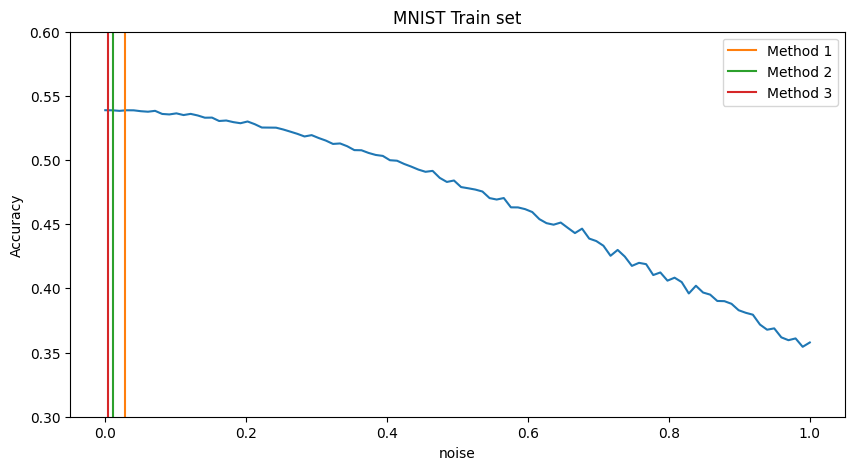

In [30]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(noises, train_accuracies)
plt.plot([ep1_train, ep1_train], [0, 1], label='Method 1')
plt.plot([ep2_train, ep2_train], [0, 1], label='Method 2')
plt.plot([ep3_train, ep3_train], [0, 1], label='Method 3')
plt.legend()
plt.ylim([0.3, 0.6])
plt.title('MNIST Train set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()

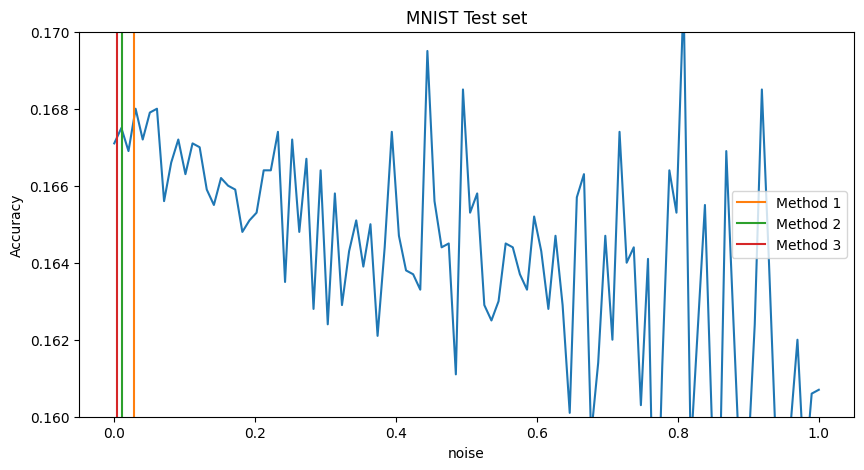

In [33]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(noises, test_accuracies)
plt.plot([ep1_test, ep1_test], [0, 1], label='Method 1')
plt.plot([ep2_test, ep2_test], [0, 1], label='Method 2')
plt.plot([ep3_test, ep3_test], [0, 1], label='Method 3')
plt.legend()
plt.ylim([0.16, 0.17])
plt.title('MNIST Test set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()